# Проект по созданию модели для прогноза количества заказов такси на следующий час

В процессе данного проекта мы проаналищируем данные по загрузке такси в 2018 году, сделаем аналитические выводы и построим прогнозную модель.

In [3]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

## Загрузка данных и предварительный осмотр

In [4]:
try:
    initial_data = pd.read_csv('taxi.csv', index_col = [0], parse_dates = [0])
except:
    initial_data = pd.read_csv('/Users/admin/Downloads/taxi.csv', index_col = [0], parse_dates = [0])
initial_data.info()
display(initial_data.describe())
initial_data.head(10)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


### Промежуточный комментарий

Итак, мы видим, что в данных всего один столбец - колчество заказов. В индексах у нас идут временные отметки с промежутком в 10 минут. Судя по распределению, выбросов нет, но есть пиковые нагрузки. Посмотрим на них в процессе анализа.

## Анализ данных

,num_orders,rolling_mean
datetime,,
2018-03-10,1267,1311.2
2018-03-11,1600,1334.8
2018-03-12,1622,1346.4
2018-03-13,1369,1354.3
2018-03-14,1278,1368.0
...,...,...
2018-08-27,3936,3306.7
2018-08-28,3357,3339.1
2018-08-29,3762,3435.2


[Text(0.5, 1.0, 'График изменения количнества заказов'),
 Text(0.5, 0, 'Дата'),
 Text(0, 0.5, 'Количество заказов')]

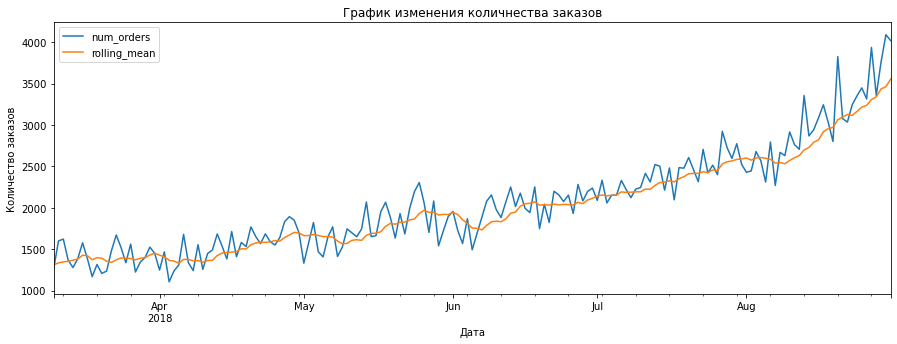

In [5]:
analysis_df = initial_data

hour_df = analysis_df.sort_index().resample('1H').sum()

day_df = analysis_df.sort_index().resample('1D').sum()
day_df['dayofweek'] = day_df.index.day_name()

analysis_df = analysis_df.resample('1D').sum()
analysis_df['rolling_mean'] = analysis_df['num_orders'].rolling(10).mean()
analysis_df.dropna(inplace = True)

display(analysis_df)
analysis_df.plot(
    figsize = (15, 5)).set(
    title = 'График изменения количнества заказов', xlabel = 'Дата', ylabel = 'Количество заказов')

### Комментарий
Сразу бросается в глаза, что в течение года количество заказов растет. Однако у нас есть данные только за полгода, так что это может быть сезонностью. Выяснить это невозможно, однако мы можм выявить некоторые другие паттерны.

[Text(0.5, 1.0, 'Сезонность в сутках'), Text(0.5, 0, 'Часы')]

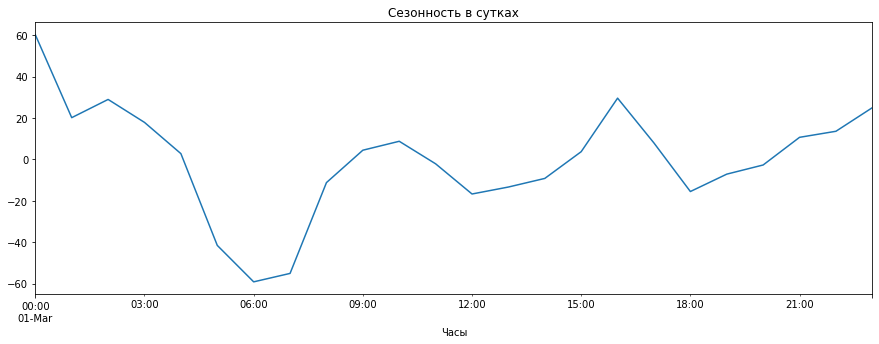

In [6]:
decomposed_hour = seasonal_decompose(hour_df)
decomposed_hour.seasonal['2018-03-01'].plot(
    ax = plt.gca(), figsize = (15, 5)).set(title = 'Сезонность в сутках', xlabel = 'Часы')

### Комментарий
Видим, что в течение суток количество заказов меняется. Пиковая нагрузка в 12 вечера, в 6 утра нагрузка минимальна. Вероятно, это обусловлено тем, что в 12 чаще всего нет альтернативного транспорта, а в 6 все спят :) В тчение дня видны колебания. Виден рост под названием "люди едут на работу" в 9-10 утра. В 16:00 есть пик - возможно, люди начинают ехать с работы. Далее обрыв в 18:00 - к этому моменту уже все заказали такси с работы. Далее плавное нарастание - люди едут отдыхать (ресторан, кино и тд) или засидевшиеся работяги начинают потихоньку собираться домой.

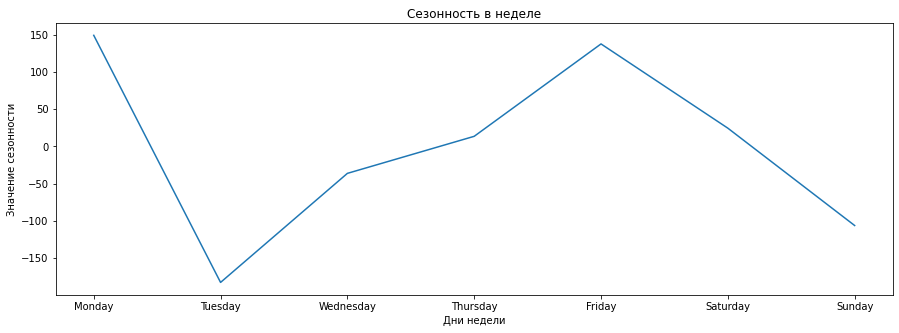

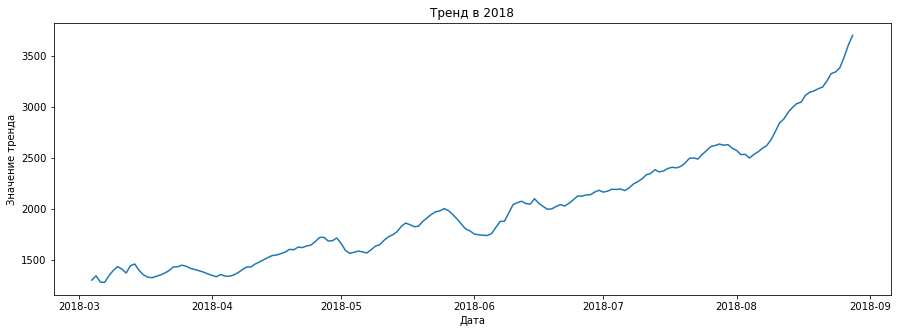

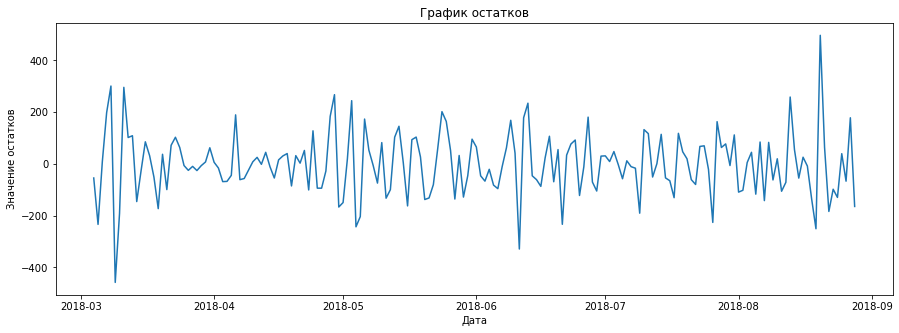

In [7]:
decomposed_day = seasonal_decompose(day_df['num_orders'])
plt.figure(figsize = (15, 5))
plt.title('Сезонность в неделе')
plt.xlabel('Дни недели')
plt.ylabel('Значение сезонности')
plt.plot(day_df['dayofweek']['2018-03-05':'2018-03-11'], decomposed_day.seasonal['2018-03-05':'2018-03-11'])
plt.show()

plt.figure(figsize = (15, 5))
plt.title('Тренд в 2018')
plt.xlabel('Дата')
plt.ylabel('Значение тренда')
plt.plot(day_df.index, decomposed_day.trend)
plt.show()

plt.figure(figsize = (15, 5))
plt.title('График остатков')
plt.xlabel('Дата')
plt.ylabel('Значение остатков')
plt.plot(day_df.index, decomposed_day.resid)
plt.show()

### Комментарий
1. Очень явная сезонность в неделе. Ближе к пятнице - больше усталость - больше лень - меньшк желания спускаться в метро - больше соблазн заказать таксишку. Плюс, вечером в пятницу же едем отдыхать?
2. Понедельник - день тяжелый. Без такси совсем уныло.
3. В воскресенье - лежим дома.

## Обучение моделей
Итак, напишем пайплайн для предобрабоитки данных, создания признаков, а дальше уже будем учиться.

In [8]:
#СОРТИРОВКА ДАТ
class Sorter(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        return data.sort_index()

#РЕСЕМПЛЕР
class Resampler(BaseEstimator, TransformerMixin):
    def __init__(self, size):
        self.size = size
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        return data.resample(self.size).sum()
    
#ВЫДЕЛЕНИЕ КАТЕГОРИЙ ИЗ ДАТ
class CatFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        data_features = data
        #разбиение на год, день и тд
        data_features['hour'] = data.index.hour
        data_features['day'] = data.index.day
        data_features['dayofweek'] = data.index.dayofweek
        data_features['month'] = data.index.month
        return data_features
    
#OHE или OrdinalEncoder для категорий - задается в пайплайне    
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns, encoder):
        self.columns = columns
        self.encoder = encoder
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        idx = data.index
        other_data = data.drop(self.columns, axis = 1)
        if self.encoder == 'OHE':
            ohe = OneHotEncoder(sparse = False)
            array_encoded = ohe.fit_transform(data[self.columns])
        elif self.encoder == 'Ordinal':
            ordenc = OrdinalEncoder()
            array_encoded = ordenc.fit_transform(data[self.columns])
        data_encoded = pd.DataFrame(array_encoded,index = idx)
        return pd.merge(data_encoded, other_data, left_index = True, right_index = True)

#ПРОСТОЙ РАЗДЕЛИТЕЛЬ
class Splitter(BaseEstimator, TransformerMixin):
    def __init__(self, test_size):
        self.test_size = test_size
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        train, test = train_test_split(data, shuffle = False, test_size = self.test_size)
        return [train, test]
    
#СТАНДАРТИЗАЦИЯ ЧИСЛЕННОГО ПРИЗНАКА
class StdScaler(BaseEstimator, TransformerMixin):
    def __init__(self, num_col):
        self.num_col = num_col
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        train = data[0]
        test = data[1]
        
        train_idx = train.index
        test_idx = test.index
        cols = train.columns
        
        scaler = StandardScaler()
        train[self.num_col + '_std'] = scaler.fit_transform(train[self.num_col].values.reshape(-1, 1))
        
        test[self.num_col + '_std'] = scaler.transform(test[self.num_col].values.reshape(-1, 1))
        return [train, test]

#ПОЛУЧЕНИЕ ДОПОЛНИТЕЛЬНЫХ ЧИСЛЕННЫХ ПРИЗНАКОВ    
class NumFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, num_col, max_log, window_size):
        self.num_col = num_col
        self.max_log = max_log
        self.window_size = window_size
        return None
    def fit(self, data):
        return self
    def transform(self, data):
        train = data[0]
        test = data[1]
        
        train_idx = train.index
        test_idx = test.index
        full_data = pd.concat([train, test])
        
        #отстающие значения
        for log in range(1, self.max_log + 1):
            full_data['log_' + str(log)] = full_data[self.num_col + '_std'].shift(log)
        #скользящее среднее

        full_data['rolling_mean'] = full_data[self.num_col + '_std'].shift().rolling(self.window_size).mean()
        return full_data.loc[train_idx].drop((self.num_col + '_std'), axis = 1).dropna(), full_data.loc[test_idx].drop((self.num_col + '_std'), axis = 1)

In [9]:
logs = 12
window = 9
#КОДИРОВАНИЕ ДАННЫХ С ПОМОЩЬЮ OneHotEncoder
pip_ohe = Pipeline([
    ('sorter', Sorter()),
    ('resampler', Resampler('1H')),
    ('catfeatures', CatFeatures()),
    ('ohe', Encoder(['hour', 'day', 'dayofweek', 'month'], encoder = 'OHE')),
    ('splitter', Splitter(test_size = 0.1)),
    ('scaler', StdScaler('num_orders')),
    ('numfeatures', NumFeatures(num_col = 'num_orders', max_log = logs, window_size = window))
])

#КОДИРОВАНИЕ ДАННЫХ С ПОМОЩЬЮ OrdinalEncoder
pip_ordenc = Pipeline([
    ('sorter', Sorter()),
    ('resampler', Resampler('1H')),
    ('catfeatures', CatFeatures()),
    ('ordenc', Encoder(['hour', 'day', 'dayofweek', 'month'], encoder = 'Ordinal')),
    ('splitter', Splitter(test_size = 0.1)),
    ('scaler', StdScaler('num_orders')),
    ('numfeatures', NumFeatures(num_col = 'num_orders', max_log = logs, window_size = window))
])

In [10]:
df = initial_data
train_ohe, test_ohe = pip_ohe.fit_transform(df)
train_ordenc, test_ordenc = pip_ordenc.fit_transform(df)

In [11]:
display(train_ohe.head(3))
display(test_ohe.head(3))
display(train_ordenc.head(3))
display(test_ordenc.head(3))

,0,1,2,3,4,5,6,7,8,9,...,log_4,log_5,log_6,log_7,log_8,log_9,log_10,log_11,log_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.145439,-1.636815,-1.714401,-1.869572,-0.912682,-0.317859,-0.188550,0.173517,1.182130,-0.860959
2018-03-01 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.240273,-1.145439,-1.636815,-1.714401,-1.869572,-0.912682,-0.317859,-0.188550,0.173517,-0.964406
2018-03-01 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.369583,-0.240273,-1.145439,-1.636815,-1.714401,-1.869572,-0.912682,-0.317859,-0.188550,-0.996015


,0,1,2,3,4,5,6,7,8,9,...,log_4,log_5,log_6,log_7,log_8,log_9,log_10,log_11,log_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.009710,1.518335,0.328688,-1.016130,-0.317859,0.121793,1.673506,2.320053,9.276899,0.639031
2018-08-13 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.699368,2.009710,1.518335,0.328688,-1.016130,-0.317859,0.121793,1.673506,2.320053,0.693628
2018-08-13 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.354550,1.699368,2.009710,1.518335,0.328688,-1.016130,-0.317859,0.121793,1.673506,1.006844


,0,1,2,3,num_orders,log_1,log_2,log_3,log_4,log_5,log_6,log_7,log_8,log_9,log_10,log_11,log_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-03-01 12:00:00,12.0,0.0,3.0,0.0,30,0.457997,-0.369583,-0.240273,-1.145439,-1.636815,-1.714401,-1.869572,-0.912682,-0.317859,-0.188550,0.173517,1.182130,-0.860959
2018-03-01 13:00:00,13.0,0.0,3.0,0.0,32,-1.248887,0.457997,-0.369583,-0.240273,-1.145439,-1.636815,-1.714401,-1.869572,-0.912682,-0.317859,-0.188550,0.173517,-0.964406
2018-03-01 14:00:00,14.0,0.0,3.0,0.0,48,-1.197163,-1.248887,0.457997,-0.369583,-0.240273,-1.145439,-1.636815,-1.714401,-1.869572,-0.912682,-0.317859,-0.188550,-0.996015


,0,1,2,3,num_orders,log_1,log_2,log_3,log_4,log_5,log_6,log_7,log_8,log_9,log_10,log_11,log_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,14.0,12.0,0.0,5.0,102,1.052821,0.354550,1.699368,2.009710,1.518335,0.328688,-1.016130,-0.317859,0.121793,1.673506,2.320053,9.276899,0.639031
2018-08-13 15:00:00,15.0,12.0,0.0,5.0,175,0.613169,1.052821,0.354550,1.699368,2.009710,1.518335,0.328688,-1.016130,-0.317859,0.121793,1.673506,2.320053,0.693628
2018-08-13 16:00:00,16.0,12.0,0.0,5.0,144,2.501086,0.613169,1.052821,0.354550,1.699368,2.009710,1.518335,0.328688,-1.016130,-0.317859,0.121793,1.673506,1.006844


### Комментарий
Все в порядке, поделили правильно.

In [12]:
target_train_ohe, target_train_ordenc = train_ohe['num_orders'], train_ordenc['num_orders']
features_train_ohe, features_train_ordenc = train_ohe.drop('num_orders', axis = 1), train_ordenc.drop('num_orders', axis = 1)

target_test_ohe, target_test_ordenc = test_ohe['num_orders'], test_ordenc['num_orders']
features_test_ohe, features_test_ordenc = test_ohe.drop('num_orders', axis = 1), test_ordenc.drop('num_orders', axis = 1)

### Комментарий
Итак, мы обработали данные, получили признаки. Можно приступать к обучению моделей.

In [13]:
num_names = ['rolling_mean']
for log in range(1, logs + 1):
    num_names.append('log_' + str(log))

In [14]:
tscv = TimeSeriesSplit(n_splits = 8)
#создаем пустые модели
best_lreg = LinearRegression(normalize = False)
tree = DecisionTreeRegressor(random_state = 42)
forest = RandomForestRegressor(random_state = 42)

categories_ohe = features_train_ohe.drop(num_names, axis = 1).columns.values
categories_ordenc = features_train_ordenc.drop(num_names, axis = 1).columns.values
sgb_ohe = LGBMRegressor(random_state = 42, n_jobs = -1, silent = True, categorical_feature = categories_ohe)
sgb_ordenc = LGBMRegressor(random_state = 42, n_jobs = -1, silent = True, categorical_feature = categories_ordenc)

#формируем сетки гиперпараметров
tree_grid = {'max_depth': range(1, 50)}
forest_grid = {'max_depth': range(1, 30), 'n_estimators': range(1, 150, 10)}
sgb_grid = {'n_estimators': range(1, 200, 10), 'max_depth': range(1, 50), 
            'learning_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 'reg_alpha': [0, 0.1, 0.2, 0.3, 0.4, 0.5], 
            'num_leaves': range(0, 50, 10)}

#готовим классы для обучения
best_tree = RandomizedSearchCV(tree, n_jobs = -1, n_iter = 9, 
                               param_distributions = tree_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = tscv)
best_forest = RandomizedSearchCV(forest, n_jobs = -1, n_iter = 9, 
                               param_distributions = forest_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = tscv)
best_sgb_ohe  = RandomizedSearchCV(sgb_ohe, n_jobs = -1, n_iter = 9, 
                               param_distributions = sgb_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = tscv)
best_sgb_ordenc  = RandomizedSearchCV(sgb_ordenc, n_jobs = -1, n_iter = 9, 
                               param_distributions = sgb_grid, random_state = 42, 
                               scoring = 'neg_mean_squared_error', cv = tscv)

In [15]:
import time
#ФУНКЦИЯ ДЛЯ АВТОМАТИЗАЦИИ ОБУЧЕНИЯ, ЗАПОМИНАНИЯ МОДЕЛЕЙ И ВЫВОДА ПАРАМЕТРОВ ОБУЧЕНИЯ
def learner(estimator, 
            name, features_train, target_train, 
            features_test, target_test):
    model_start = time.time()
    estimator.fit(features_train, target_train)

    model_end = time.time()
    test_predictions = estimator.predict(features_test)
    predict_end = time.time()
    learning_time = model_end - model_start
    predict_time = predict_end - model_end
    rmse = mean_squared_error(target_test, test_predictions) ** 0.5
    try:
        params = estimator.best_params_
        print('Подобранные гиперпараметры:', params)
        print('Оценка модели', name,' RMSE =', rmse)
        print('Время, потраченное на обучение модели:', learning_time, 'сек.')
        print('Время, потраченное на инференс:', predict_time)
        print()
        return pd.Series([estimator, params, rmse, learning_time, predict_time], 
                         index = ['Модель', 'Гиперпараметры', 'RMSE', 'Время обучения', 'Время инференса'])
    except:
        params = estimator.get_params()
        print('Подобранные гиперпараметры:', params)
        print('Оценка модели', name,' RMSE =', rmse)
        print('Время, потраченное на обучение модели:', learning_time, 'сек.')
        print('Время, потраченное на инференс:', predict_time)
        print()
        return pd.Series([estimator, params, rmse, learning_time, predict_time], index = ['Модель', 'Гиперпараметры', 'RMSE', 'Время обучения', 'Время инференса'])

In [16]:
models = pd.Series([best_lreg, best_tree, best_forest, best_sgb_ordenc], 
                   index = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг'])
result_ordenc = pd.DataFrame(columns = ['Модель','Гиперпараметры' , 'RMSE', 'Время обучения', 'Время инференса'])
for idx in ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг']:
    result_ordenc = result_ordenc.append(learner(models[idx], features_train = features_train_ordenc, 
                                       target_train = target_train_ordenc,
                                       features_test = features_test_ordenc,
                                       target_test = target_test_ordenc, name = idx), ignore_index = True)

Подобранные гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
Оценка модели Линейная регрессия  RMSE = 52.44636833665628
Время, потраченное на обучение модели: 0.019625186920166016 сек.
Время, потраченное на инференс: 0.0018451213836669922

Подобранные гиперпараметры: {'max_depth': 14}
Оценка модели Решающее дерево  RMSE = 52.267791664466344
Время, потраченное на обучение модели: 1.838573932647705 сек.
Время, потраченное на инференс: 0.0009350776672363281

Подобранные гиперпараметры: {'n_estimators': 121, 'max_depth': 22}
Оценка модели Случайный лес  RMSE = 44.096161120717376
Время, потраченное на обучение модели: 15.402217149734497 сек.
Время, потраченное на инференс: 0.01397085189819336

Подобранные гиперпараметры: {'reg_alpha': 0.4, 'num_leaves': 20, 'n_estimators': 91, 'max_depth': 43, 'learning_rate': 0.1}
Оценка модели Градиентный бустинг  RMSE = 40.52125098100006
Время, потраченное на обучение модели: 2.138399124145508

In [17]:
models = pd.Series([best_lreg, best_tree, best_forest, best_sgb_ohe], 
                   index = ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг'])
result_ohe = pd.DataFrame(columns = ['Модель','Гиперпараметры' , 'RMSE', 'Время обучения', 'Время инференса'])
for idx in ['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг']:
    result_ohe = result_ohe.append(learner(models[idx], features_train = features_train_ohe, 
                                       target_train = target_train_ohe,
                                       features_test = features_test_ohe,
                                       target_test = target_test_ohe, name = idx), ignore_index = True)

Подобранные гиперпараметры: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
Оценка модели Линейная регрессия  RMSE = 43.97341429601587
Время, потраченное на обучение модели: 0.043143272399902344 сек.
Время, потраченное на инференс: 0.003085613250732422

Подобранные гиперпараметры: {'max_depth': 14}
Оценка модели Решающее дерево  RMSE = 50.566509443860774
Время, потраченное на обучение модели: 0.7801311016082764 сек.
Время, потраченное на инференс: 0.0014178752899169922

Подобранные гиперпараметры: {'n_estimators': 121, 'max_depth': 22}
Оценка модели Случайный лес  RMSE = 43.35861511317947
Время, потраченное на обучение модели: 23.17839813232422 сек.
Время, потраченное на инференс: 0.01283574104309082

Подобранные гиперпараметры: {'reg_alpha': 0.4, 'num_leaves': 20, 'n_estimators': 91, 'max_depth': 43, 'learning_rate': 0.1}
Оценка модели Градиентный бустинг  RMSE = 41.6404559353515
Время, потраченное на обучение модели: 2.4511117935180664 с

In [18]:
for result in result_ordenc, result_ohe:
    result.set_axis(['Линейная регрессия', 'Решающее дерево', 'Случайный лес', 'Градиентный бустинг'], axis = 0)
    display(result.drop(['Модель', 'Гиперпараметры'], axis = 1))

,RMSE,Время обучения,Время инференса
0,52.446368,0.019625,0.001845
1,52.267792,1.838574,0.000935
2,44.096161,15.402217,0.013971
3,40.521251,2.138399,0.002199


,RMSE,Время обучения,Время инференса
0,43.973414,0.043143,0.003086
1,50.566509,0.780131,0.001418
2,43.358615,23.178398,0.012836
3,41.640456,2.451112,0.002644


## Результат
Так, мы получили 8 моделей. Результаты обучения и тестирования мы можем видеть в двух таблицах выше (первая таблица - модели, обученные на данных с кодировкой OrdinalEncoder, вторая - OneHotEncoder). 

Небольшой обзор результатов:
1. Мы совсем не зря "намножили" данных с разными кодировками: три из четырех моделей лучше обучились на OHE.
2. Мы хорошо подготовили данные: больше половины моделей удовлетворяют условию RMSE <= 48.
3. Лучшая модель - Градиентный бустинг, обученный на данных с кодировкой OrdinalEncoder. RMSE = 39.8, время обучения = 550 секунд, время предсказания = 0.1 секунды. Качество супер, но время обучения великовато :(
Я вполне доволен результатом, но на всякий случай проверим модель на адекватность.

In [19]:
def median(target_train, target_test):
    median_value = target_train.median()
    prediction = np.ones(len(target_test)) * median_value
    return mean_squared_error(target_test, prediction) ** 0.5
def last_element(target_train, target_test):
    last_value = target_train.tail(1).values
    prediction = np.ones(len(target_test)) * last_value
    return mean_squared_error(target_test, prediction) ** 0.5
print('RMSE константной модели, основанной на медиане равно', median(target_train_ohe, target_test_ohe))
print('RMSE константной модели, основанной на медиане равно', last_element(target_train_ohe, target_test_ohe))

RMSE константной модели, основанной на медиане равно 87.15277582981295
RMSE константной модели, основанной на медиане равно 62.05343632125475


## Итог
Супер! Все наши модели прошли проверку на адекватноть, так что градиентный бустинг LightGBM остается лучшей моделью. Запишем ее в `best_model` и конец!

In [20]:
best_model = result_ordenc['Модель'][3]

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48